In [1]:
##Import Modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.svm import SVC
from sklearn.utils import resample, shuffle
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score, recall_score, classification_report, f1_score
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.model_selection import validation_curve
from sklearn.preprocessing import StandardScaler

def balance(data): #sample it down to 1200 to balance out
    zero = data[data['Potability']==0] #has 1200
    one = data[data['Potability']==1] #has 811
    resampledData = resample(one, n_samples=1200)
    updatedData = shuffle(pd.concat([zero, resampledData]))
    return updatedData

def variableClean(data):
    indepVariable = data.drop('Potability', axis=1).copy()
    depVariable = data['Potability'].copy()
    scal = StandardScaler()
    features = indepVariable.columns
    indepVariable[features] = scal.fit_transform(indepVariable[features])
    return indepVariable, depVariable

def getMax(arr):
    maxVal = -1
    index = -1
    for i in range(len(arr)):
        if(maxVal < arr[i]):
            maxVal = arr[i]
            index = i
    return {'index': index,
           'maximum_value': maxVal}

def getScore(trainSize, testMean):
    max_test = getMax(testMean)
    index = max_test['index']
    maxValue = max_test['maximum_value']
    optimalTrainSize = trainSize[index]
    conclusion = f'With the train size of {optimalTrainSize} yields the score of {maxValue}.'
    return conclusion

def prediction(df, xTrain, yTrain, xTest, yTest):
    output = {}
    start = time.time()
    df.fit(xTrain, yTrain)
    test_pred = df.predict(xTest)
    cRep = classification_report(yTest, test_pred, digits=4)
    f1Score = f1_score(yTest, test_pred)
    end = time.time()
    wallClockPred = end - start
    outputUpdate = (('classification_report', cRep), ('f1_score', f1Score), ('wall_clock', wallClockPred))
    output.update(outputUpdate)
    return output

def printPredictions(pred):
    print('Time spent for prediction: ', pred['wall_clock'])
    print(pred['classification_report'])
    print('f1-Score: ', pred['f1_score'])


[learning_curve] Training set sizes: [  21   43   64   86  108  129  151  172  194  215  237  259  280  302
  324  345  367  388  410  432  453  475  496  518  540  561  583  604
  626  648  669  691  712  734  756  777  799  820  842  864  885  907
  928  950  972  993 1015 1036 1058 1080 1101 1123 1144 1166 1188 1209
 1231 1252 1274 1296 1317 1339 1360 1382 1404 1425 1447 1468 1490 1512
 1533 1555 1576 1598 1620 1641 1663 1684 1706 1728 1749 1771 1792 1814
 1836 1857 1879 1900 1922 1944 1965 1987 2008 2030 2052 2073 2095 2116
 2138 2160]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  92 out of 1000 | elapsed:    7.5s remaining:  1.2min
[Parallel(n_jobs=-1)]: Done 193 out of 1000 | elapsed:   12.9s remaining:   53.9s
[Parallel(n_jobs=-1)]: Done 294 out of 1000 | elapsed:   18.1s remaining:   43.6s
[Parallel(n_jobs=-1)]: Done 395 out of 1000 | elapsed:   23.4s remaining:   35.8s
[Parallel(n_jobs=-1)]: Done 496 out of 1000 | elapsed:   28.7s remaining:   29.1s
[Parallel(n_jobs=-1)]: Done 597 out of 1000 | elapsed:   33.9s remaining:   22.9s
[Parallel(n_jobs=-1)]: Done 698 out of 1000 | elapsed:   39.2s remaining:   17.0s
[Parallel(n_jobs=-1)]: Done 799 out of 1000 | elapsed:   44.6s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done 900 out of 1000 | elapsed:   50.0s remaining:    5.6s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   56.0s finished


'With the train size of 2160 yields the score of 0.6962499999999999.'

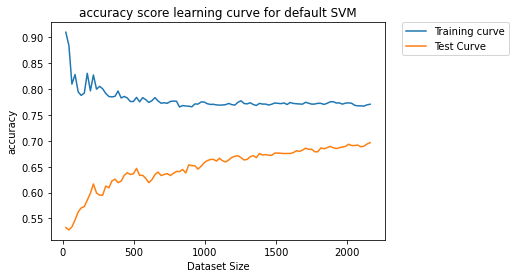

In [11]:
##Data source: https://www.kaggle.com/adityakadiwal/water-potability
original_data = pd.read_csv('/Users/jacobseo/cs7641/assignment1/data/water_potability.csv')
df = original_data.copy()
df = df.dropna()

df = balance(df)
df.Potability.value_counts()

X, y = variableClean(df)

##Default learning Curve
train_sizes, train_scores, test_scores = learning_curve(SVC(random_state=42), X, y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01,1.0,100), verbose=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training curve')
plt.plot(train_sizes, test_mean, label='Test Curve')
plt.xlabel("Dataset Size")
plt.ylabel("accuracy")
plt.title("accuracy score learning curve for default SVM")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

getScore(train_sizes, test_mean)

In [62]:
##Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

##GridSearch rbf Kernel
params ={
    'C': [0.1, 0.3, 0.5, 1, 1.5, 2, 2.5, 3, 5],
    'gamma': [0.5, 1, 2, 3, 4, 5, 6, 7],
}

gs = GridSearchCV(SVC(random_state=42), param_grid=params, cv=10, n_jobs=-1, verbose=10, return_train_score=True, scoring='accuracy')
gs.fit(X_train, y_train)

##Best Results
best_parameter = gs.best_params_
best_score = gs.best_score_

print("best parameter: ", best_parameter)
print("best score: ", best_score)

Fitting 10 folds for each of 72 candidates, totalling 720 fits
best parameter:  {'C': 1, 'gamma': 3}
best score:  0.8412037037037038


In [63]:
results_data = pd.DataFrame(gs.cv_results_)
param_keys = list(params.keys())
optimal_results_data = results_data.loc[(results_data['param_'+param_keys[1]]==best_parameter[param_keys[1]])]
optimal_results_data

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
3,0.305110,0.014585,0.081548,0.003365,0.1,3,"{'C': 0.1, 'gamma': 3}",0.504630,0.504630,0.504630,...,0.501029,0.501543,0.501543,0.501543,0.501543,0.501543,0.501543,0.501543,0.501389,0.000236
11,0.305160,0.012896,0.082906,0.008397,0.3,3,"{'C': 0.3, 'gamma': 3}",0.578704,0.564815,0.564815,...,0.674383,0.686214,0.840021,0.674897,0.687243,0.681584,0.675926,0.715021,0.699383,0.048213
19,0.342761,0.023091,0.083816,0.005334,0.5,3,"{'C': 0.5, 'gamma': 3}",0.675926,0.689815,0.703704,...,0.855453,0.851337,0.855453,0.852881,0.855453,0.848765,0.853395,0.851337,0.853035,0.002045
27,0.362633,0.008623,0.079791,0.001789,1,3,"{'C': 1, 'gamma': 3}",0.847222,0.847222,0.833333,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
35,0.345869,0.007935,0.072669,0.003204,1.5,3,"{'C': 1.5, 'gamma': 3}",0.847222,0.847222,0.833333,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
43,0.349674,0.010813,0.069909,0.003236,2,3,"{'C': 2, 'gamma': 3}",0.847222,0.847222,0.833333,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
51,0.339753,0.011879,0.069123,0.002682,2.5,3,"{'C': 2.5, 'gamma': 3}",0.847222,0.847222,0.833333,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
59,0.333210,0.009167,0.067544,0.001875,3,3,"{'C': 3, 'gamma': 3}",0.847222,0.847222,0.833333,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
67,0.326211,0.005326,0.066371,0.002600,5,3,"{'C': 5, 'gamma': 3}",0.847222,0.847222,0.833333,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000


Text(0.5, 1.0, 'Validation for the SVM')

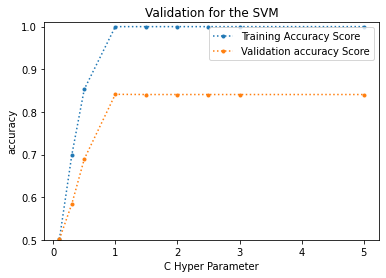

In [64]:
##GridSearch Plotting
fig, ax = plt.subplots()
optimal_results_data.plot(x='param_'+param_keys[0], y='mean_train_score', label='Training Accuracy Score', ax=ax, marker='.', ls=':')
optimal_results_data.plot(x='param_'+param_keys[0], y='mean_test_score', label='Validation accuracy Score', ax=ax, marker='.', ls=':')

ax.set_xlabel('C Hyper Parameter')
ax.set_ylabel('accuracy')
ax.set_ylim(bottom=0.5, top=1.01)
ax.set_title("Validation for the SVM")

[learning_curve] Training set sizes: [  21   65  108  152  196  239  283  327  370  414  458  501  545  588
  632  676  719  763  807  850  894  938  981 1025 1068 1112 1156 1199
 1243 1287 1330 1374 1418 1461 1505 1549 1592 1636 1679 1723 1767 1810
 1854 1898 1941 1985 2029 2072 2116 2160]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of 500 | elapsed:    2.6s remaining:   28.6s
[Parallel(n_jobs=-1)]: Done  93 out of 500 | elapsed:    5.8s remaining:   25.3s
[Parallel(n_jobs=-1)]: Done 144 out of 500 | elapsed:    9.0s remaining:   22.3s
[Parallel(n_jobs=-1)]: Done 195 out of 500 | elapsed:   12.0s remaining:   18.8s
[Parallel(n_jobs=-1)]: Done 246 out of 500 | elapsed:   15.1s remaining:   15.6s
[Parallel(n_jobs=-1)]: Done 297 out of 500 | elapsed:   18.3s remaining:   12.5s
[Parallel(n_jobs=-1)]: Done 348 out of 500 | elapsed:   21.4s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done 399 out of 500 | elapsed:   24.6s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done 450 out of 500 | elapsed:   27.9s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   31.6s finished


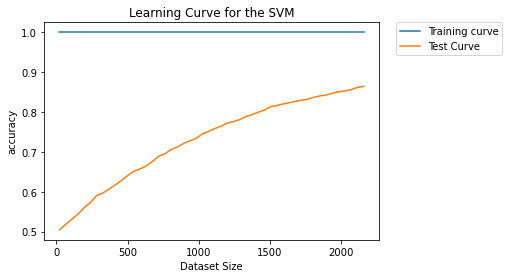

In [65]:
##learning Curve - rbf KERNEL
optimal_df = SVC(random_state=42, C=best_parameter[param_keys[0]], gamma=best_parameter[param_keys[1]])
train_sizes, train_scores, test_scores = learning_curve(optimal_df, X, y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01,1.0,50), verbose=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training curve')
plt.plot(train_sizes, test_mean, label='Test Curve')
plt.xlabel("Dataset Size")
plt.ylabel("accuracy")
plt.title("Learning Curve for the SVM")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [66]:
##Predictions
pred = prediction(optimal_df, X_train, y_train, X_test, y_test)
printPredictions(pred)

Time spent for prediction:  0.31906890869140625
              precision    recall  f1-score   support

           0     0.7987    1.0000    0.8881       123
           1     1.0000    0.7350    0.8473       117

    accuracy                         0.8708       240
   macro avg     0.8994    0.8675    0.8677       240
weighted avg     0.8968    0.8708    0.8682       240

f1-Score:  0.8472906403940887


In [71]:
##Training and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

##GridSearch linear
params ={
    'C': [0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6],
    'gamma': [0.0001, 0.001, 0.1, 1, 2, 5, 8],
}

gs = GridSearchCV(SVC(random_state=42, kernel='linear'), param_grid=params, cv=10, n_jobs=-1, verbose=10, return_train_score=True, scoring='accuracy')
gs.fit(X_train, y_train)

##Best Results
best_parameter = gs.best_params_
best_score = gs.best_score_

print("best parameter: ", best_parameter)
print("best score: ", best_score)

Fitting 10 folds for each of 56 candidates, totalling 560 fits
best parameter:  {'C': 0.6, 'gamma': 0.0001}
best score:  0.5231481481481483


In [72]:
results_data = pd.DataFrame(gs.cv_results_)
param_keys = list(params.keys())
optimal_results_data = results_data.loc[(results_data['param_'+param_keys[1]]==best_parameter[param_keys[1]])]
optimal_results_data

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.259910,0.010364,0.022172,0.000489,0.2,0.0001,"{'C': 0.2, 'gamma': 0.0001}",0.49537,0.518519,0.550926,...,0.525206,0.545267,0.546811,0.530350,0.544239,0.533951,0.534979,0.526235,0.536111,0.007908
7,0.280857,0.026386,0.021756,0.000901,0.4,0.0001,"{'C': 0.4, 'gamma': 0.0001}",0.49537,0.518519,0.560185,...,0.527263,0.545267,0.547840,0.531893,0.543210,0.534979,0.534979,0.526749,0.536626,0.007591
14,0.310467,0.015827,0.022267,0.000823,0.6,0.0001,"{'C': 0.6, 'gamma': 0.0001}",0.49537,0.518519,0.560185,...,0.528292,0.545267,0.547840,0.530864,0.545267,0.534465,0.534465,0.526749,0.536677,0.007720
21,0.310012,0.005167,0.022852,0.002529,0.8,0.0001,"{'C': 0.8, 'gamma': 0.0001}",0.49537,0.518519,0.560185,...,0.527263,0.545267,0.547840,0.530864,0.545267,0.531893,0.532922,0.526749,0.536163,0.007992
28,0.332070,0.012914,0.022702,0.001708,1,0.0001,"{'C': 1, 'gamma': 0.0001}",0.49537,0.518519,0.560185,...,0.527263,0.545782,0.547840,0.533436,0.545267,0.531893,0.532922,0.526749,0.536523,0.007969
35,0.424362,0.016239,0.027482,0.003471,1.2,0.0001,"{'C': 1.2, 'gamma': 0.0001}",0.49537,0.513889,0.560185,...,0.528292,0.545267,0.547840,0.534979,0.544239,0.531893,0.530350,0.526749,0.536265,0.007900
42,0.444374,0.012718,0.024253,0.002204,1.4,0.0001,"{'C': 1.4, 'gamma': 0.0001}",0.49537,0.513889,0.560185,...,0.527263,0.545782,0.547840,0.534465,0.544239,0.531893,0.531893,0.526749,0.536368,0.007929
49,0.706159,0.056947,0.034788,0.013847,1.6,0.0001,"{'C': 1.6, 'gamma': 0.0001}",0.49537,0.513889,0.560185,...,0.527263,0.546296,0.547840,0.534979,0.545267,0.531893,0.532407,0.526749,0.536626,0.008058


Text(0.5, 1.0, 'Validation for the SVM')

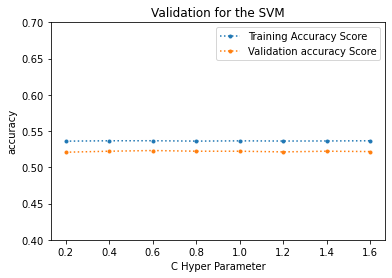

In [73]:
##GridSearch Plotting
fig, ax = plt.subplots()
optimal_results_data.plot(x='param_'+param_keys[0], y='mean_train_score', label='Training Accuracy Score', ax=ax, marker='.', ls=':')
optimal_results_data.plot(x='param_'+param_keys[0], y='mean_test_score', label='Validation accuracy Score', ax=ax, marker='.', ls=':')

ax.set_xlabel('C Hyper Parameter')
ax.set_ylabel('accuracy')
ax.set_ylim(bottom=0.4, top=0.70)
ax.set_title("Validation for the SVM")

[learning_curve] Training set sizes: [  21   65  108  152  196  239  283  327  370  414  458  501  545  588
  632  676  719  763  807  850  894  938  981 1025 1068 1112 1156 1199
 1243 1287 1330 1374 1418 1461 1505 1549 1592 1636 1679 1723 1767 1810
 1854 1898 1941 1985 2029 2072 2116 2160]


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of 500 | elapsed:    1.5s remaining:   16.6s
[Parallel(n_jobs=-1)]: Done  93 out of 500 | elapsed:    3.1s remaining:   13.5s
[Parallel(n_jobs=-1)]: Done 144 out of 500 | elapsed:    4.5s remaining:   11.2s
[Parallel(n_jobs=-1)]: Done 195 out of 500 | elapsed:    6.0s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done 246 out of 500 | elapsed:    7.5s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done 297 out of 500 | elapsed:    8.9s remaining:    6.1s
[Parallel(n_jobs=-1)]: Done 348 out of 500 | elapsed:   10.4s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done 399 out of 500 | elapsed:   11.9s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done 450 out of 500 | elapsed:   13.4s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   15.1s finished


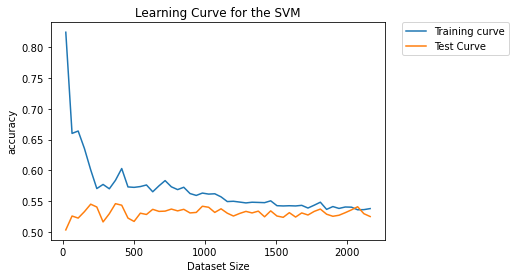

In [74]:
##learning Curve - poly
optimal_df = SVC(random_state=42, kernel='linear', C=1, gamma=1)
train_sizes, train_scores, test_scores = learning_curve(optimal_df, X, y, cv=10, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.01,1.0,50), verbose=10)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, label='Training curve')
plt.plot(train_sizes, test_mean, label='Test Curve')
plt.xlabel("Dataset Size")
plt.ylabel("accuracy")
plt.title("Learning Curve for the SVM")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

In [75]:
##Predictions
pred = prediction(optimal_df, X_train, y_train, X_test, y_test)
printPredictions(pred)

Time spent for prediction:  0.2434699535369873
              precision    recall  f1-score   support

           0     0.4965    0.5691    0.5303       123
           1     0.4646    0.3932    0.4259       117

    accuracy                         0.4833       240
   macro avg     0.4806    0.4811    0.4781       240
weighted avg     0.4809    0.4833    0.4794       240

f1-Score:  0.4259259259259259
